# The $\texttt{locator}$ class

In [1]:
%pylab
from scipy import signal
from scipy.io import wavfile as wav
import locator

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib



The $\texttt{locator}$ class has the functionality to artificially shift a signal to simulate as if it had come from some position in space, or to load in actual array data to process. To begin the demonstration, we will create a file which comprises of white noise, and then artificially shift it to position $\theta = \pi/5$.

## Create the noise file

In [2]:
noise = random.normal(0., 1., size=44100//5)
noise *= 2**15/max(noise)
wav.write("noisedemo.wav", 44100, noise)

## Instantiate a $\texttt{locator}$

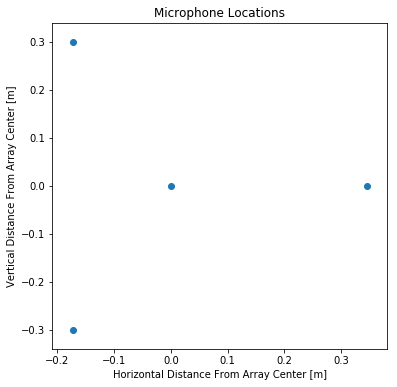

In [3]:
# Setting up graphical environment
%matplotlib inline
rcParams['figure.figsize'] = [6, 6]

loc = locator.Locator(mic_locations=locator.UCA(4, 0.346, centerpoint=True, show=True))

## Shift the mono file created earlier to $\theta = \pi/5$, then load it.
The $\texttt{shift_sound}$ method actually takes in a position $(x, y)$ as it's position arguement, because some of the methods implemented in the $\texttt{locator}$ work for near-field sources as well as far-field. In this case, we'll just shift the source very, very, far away.

In [4]:
# Define an (x,y) tuple for the source position
source_position = (100000*cos(pi/5), 100000*sin(pi/5))

# Artificially shift the source to that position.
loc.shift_sound(source_position, "noisedemo.wav", "noisedemoSHIFTED.wav", noisescale=0.0)

You may notice that the $\texttt{shift_sound}$ method has a "noisescale" parameter. You can introduce artificial noise in the data with this parameter. It generates Gaussian iid noise with mean 0 and variance $\texttt{noisescale}$ times the variance of the signal itself.

In [5]:
# Load the newly-shifted file.
loc.load("noisedemoSHIFTED.wav", GCC_processor="CC")

The $\texttt{load}$ method also generates the weighted cross-correlation functions using the weighting specified by $\texttt{GCC_processor}$ (you can use CC, PHAT, RIR, or SCOT). You can stop this by giving passing the parameter $\texttt{do_FFTs=False}$.

If you'd like to filter out all frequencies which are above the spatial Nyquist frequency for the current array, you can do so automatically by calling $\texttt{loc.filter_aliased}()$.

# Now it's time to try and locate our source

GCC-based methods available are:
    - display_heatmap()
    - display_radial()

MUSIC-based methods available are:
    - display_radMUSIC(frequency)
    - display_MUSICheatmap(frequency)
    
AF-MUSIC-based methods available are:
    - AF_MUSIC()
    - AF_MUSIC2D()

## Let's try the GCC-based methods first

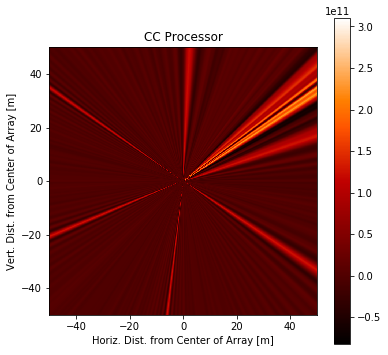

In [6]:
loc.display_heatmap()

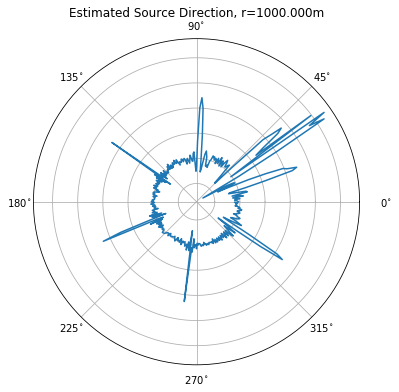

In [7]:
loc.display_radial(1000)

## Now let's try the MUSIC-based ones
For these I just picked an arbitrary frequency to use, as theoretically the white noise signal should have equal power at all frequencies.

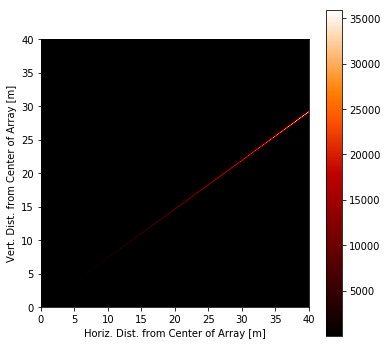

In [10]:
loc.display_MUSICheatmap(500, xrange=(0,40), yrange=(0,40), xstep=0.01, ystep=0.01)

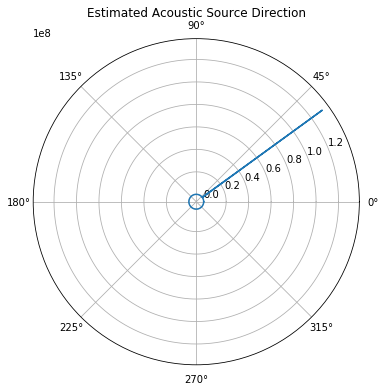

In [9]:
loc.display_radMUSIC(500)

## Now for AF-MUSIC
The AF-MUSIC algorithm does not require the selection of a single frequency to work on, and as such does not require any arguments.

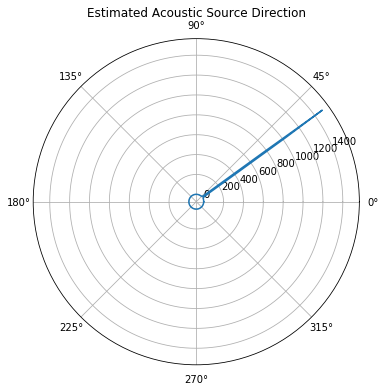

In [10]:
loc.AF_MUSIC()

# Both algorithms appear to work well on the simulation with no noise. But do they work for real data?
Let's try it, in principle the $\texttt{Locator}$ is used in exactly the same way. The file "kdemo.wav" was recorded as part of a larger experiment on how array size effects the localisation ability of the array. It was captured with a 0.346m radius 4-element UCA with one microphone in the center (the same shape as in the simulations above). The source was placed at an angle of 0 degrees from the array at a distance of 8m.

In [11]:
# First, load the file
l_exp = locator.Locator(mic_locations=locator.UCA(n=4, r=0.346, centerpoint=True))
l_exp.load("kdemo.wav")

## First try the GCC-based heatmap and radial plot.

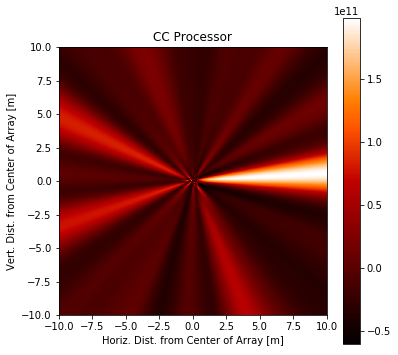

In [12]:
l_exp.display_heatmap(xrange=(-10,10), yrange=(-10,10))

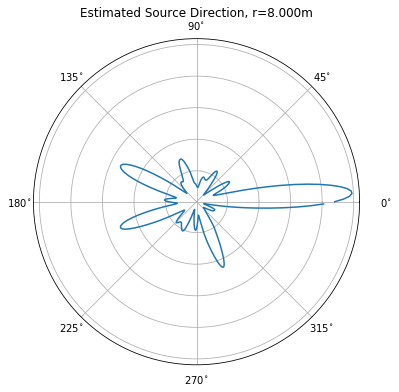

In [13]:
l_exp.display_radial(8)

## Now for MUSIC. But at which frequency?
First, we have a look at the fourier transform of the recorded call of the female North Island Brown Kiwi. The frequency with the highest magnitude seems to be a sensible choice, as it contributes the most to the data.

Text(0.5,0,'Frequency [Hz]')

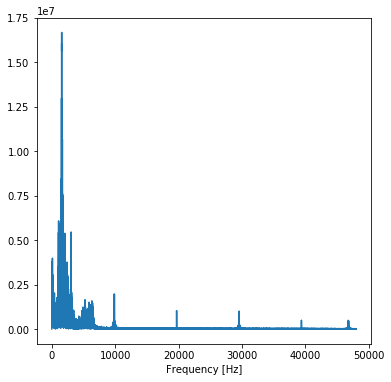

In [14]:
plot(fft.rfftfreq(l_exp.data[:,0].shape[0])*l_exp.sample_rate, np.abs(fft.rfft(l_exp.data[:,0])))
xlabel("Frequency [Hz]")

Notice how the power is spread out over a large range of frequencies.

In [15]:
frq = fft.rfftfreq(l_exp.data[:,0].shape[0])[argmax(np.abs(fft.rfft(l_exp.data[:,0])))]*l_exp.sample_rate
print("The frequency with highest power is", frq, "Hz")

The frequency with highest power is 1559.2987858217573 Hz


We will then use this frequency as the choice for running the MUSIC algorithm on.

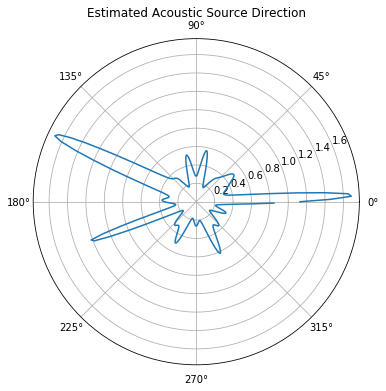

In [16]:
l_exp.display_radMUSIC(frq)

For the ~1559Hz component of the signal, it appears that the kiwi call at 0 degrees is not the only active source; notice there are mutliple peaks in the output. 

## To get around frequency selection, try AF-MUSIC
Rather than pick one frequency for localisation, by using AF-MUSIC we may combine the information available at all frequencies in the data, like so:

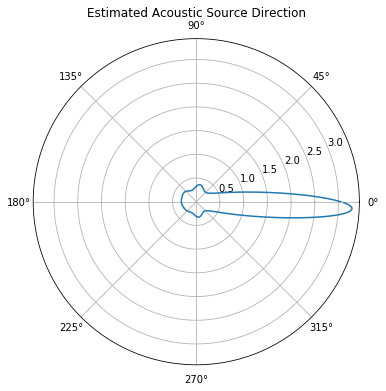

In [17]:
l_exp.AF_MUSIC()

# Runtime Comparison
As AF-MUSIC combines the information available at all frequencies, there is a lot more computation involved.
Indeed, regular MUSIC takes approximately 34 milliseconds per run:

In [18]:
%%timeit
_ = l_exp.display_radMUSIC(frq, shw=False)

33.9 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Whereas AF-MUSIC takes around 3.9 seconds.

In [19]:
%%timeit
_ = l_exp.AF_MUSIC(shw=False)

3.66 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For comparison, the cross-correlation based method only takes around 9 milliseconds.

In [20]:
%%timeit
_ = l_exp.display_radial(8, shw=False)

8.91 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
